# This notebook takes in netCDF based climate model preditions and formats them for use in the SWB model 

### Note I went back in June 24th 2020 and multiplied all of the rainfall scenarios by 1.65 in order to correct for the fact that the present day severely underestimated the actual present day rainfall.   Thus the RCP scenarios are multiplied by 1.65 too meaning they predict LOTS of rain!

Some notes: 
- The projection on these files seems messed up. Therefore I had to manually move them over somewhat to line them up with what I estimated to be the right spot
- So far I have only done rainfall. If I wanted to do temperature too I would fhave to do the temp max and min...

In [2]:
# make the screen bigger!
from IPython.display import display, HTML
display(HTML(data=""" <style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 85%; }
    div#maintoolbar-container { width: 99%; } </style> """))

# modules
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pyproj import Proj, transform
import pandas as pd
%matplotlib inline

# functions 
def writeArrayToArcGrid(arr,filename,xll,yll,cellsize,no_data_val):
    """ this takes a 2d numpy array and turns it into an .asc file """
    arr                = np.copy(arr)
    arr[np.isnan(arr)] = no_data_val
    headerstring       = bytes('NCOLS %d\nNROWS %d\nXLLCENTER %f\nYLLCENTER %f\nCELLSIZE %f\nNODATA_value %f\n' % 
        (arr.shape[1], arr.shape[0], xll, yll, cellsize, no_data_val), 'UTF-8')

    with open(filename,'wb') as fout:
        fout.write(headerstring)
        np.savetxt(fout,arr,'%5.2f')
        
# Paths
Datapath = os.path.join(".", 'RawData')
Outpath =  os.path.join(".", 'ProcessedData')

Rain_present = Datapath +'\\'+'samoa_hourly_present_RAIN_1990-2009.nc'
Rain_rcp45 = Datapath +'\\'+'samoa_hourly_rcp45_RAIN_1990-2009.nc'
Rain_rcp85 = Datapath +'\\'+'samoa_hourly_rcp85_RAIN_1990-2009.nc'

Temp_present = Datapath +'\\'+'samoa_hourly_present_T2_1990-2009.nc'
Temp_rcp45 = Datapath +'\\'+'samoa_hourly_rcp45_T2_1990-2009.nc'
Temp_rcp85 = Datapath +'\\'+'samoa_hourly_rcp85_T2_1990-2009.nc'

C:\Users\cshuler\AppData\Local\Continuum\anaconda3\envs\GIS_env\lib\site-packages\xarray\core\common.py:671: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  return self._groupby_cls(


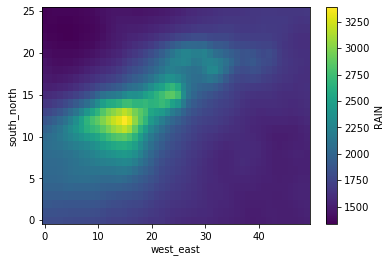

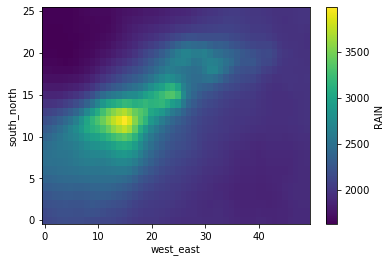

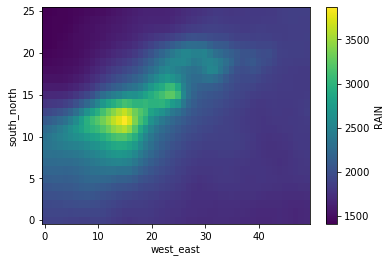

In [4]:
# load up all the rainfall data files 

data_R_p = xr.open_dataset(Rain_present)    # open up the nc file
data_R_45 = xr.open_dataset(Rain_rcp45)    
data_R_85 = xr.open_dataset(Rain_rcp85)    

rain_variable_R_p = data_R_p['RAIN']            # select the rain variable (has time, lat and lon dimentions)
rain_variable_R_45 = data_R_45['RAIN']  
rain_variable_R_85 = data_R_85['RAIN']  

#monthly_R_p = rain_variable.groupby('Time.month').sum(dim='Time')   # turn it into a set of 12 time arrays one for each month (all 20 years of data ADDED together for each month) 
#monthly_R_p = monthly/20    # this is because the dataset is 20 years long, now er have average monthly values from the 20 year dataset, but for one month

yearly_R_p = rain_variable_R_p.groupby('Time.year').sum(dim='Time')    # turn it into 20 time arrays one for each year
yearly_R_45 = rain_variable_R_45.groupby('Time.year').sum(dim='Time')
yearly_R_85 = rain_variable_R_85.groupby('Time.year').sum(dim='Time')

yearlyave_R_p = np.mean(yearly_R_p, 0)                                 # Average all the years together into a single average yearly dataset
yearlyave_R_45 = np.mean(yearly_R_45, 0) 
yearlyave_R_85 = np.mean(yearly_R_85, 0) 

yearlyave_R_p.plot(); plt.show()            # plot if want
yearlyave_R_45.plot() ; plt.show()
yearlyave_R_85.plot() ; plt.show()

### Rainfall Data Yearly loop, also this defines some of the geometry attributes used in the monthly ones so need to run first

#### Also need to take the Prizm anual rainfall and divide it by the GCM annual rainfall, this not only makes an interesting difference map, but the cells have a mean anomoly of: 
###  1.685140994616917 +-  0.2547
  so we need to multiply all the rainfall from the GCM outputs by 1.685 to make the climate scenarios behave realistically

In [11]:
scene_list = [yearlyave_R_p,  yearlyave_R_45,  yearlyave_R_85]     # list of the processed yearly average arrays from above
name_list = ["present", "rcp45", "rcp85"]                          # names 

# this little block does some projection from WGS 84 to UTM2  but just for getting the corner values really, 
# projection definitions
inProj = Proj("+proj=latlon +ellps=WGS84 + datum=WGS84 +no_defs +towgs84=0,0,0")
outProj = Proj("+proj=utm +zone=2 +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs ")
LonData = np.array(data_R_p['XLONG']).flatten()
LatData = np.array(data_R_p['XLAT']).flatten()
LonDataUTM, LatDataUTM = transform(inProj, outProj, LonData , LatData)
MaxY = round(max(LatDataUTM))
MinY = round(min(LatDataUTM))
MaxX = round(max(LonDataUTM))
MinX = round(min(LonDataUTM))
Lx = MaxX - MinX
Ly = MaxY - MinY
Dy = Lx/50
Dx = Ly/26
XLLCORNER =  MinX+2800        # so the projection of the NETCDF file seems to be messed up. I Substituted these numbers in to transform it to more reasonable values
YLLCORNER = MinY+400

# this then writes the array to an asc file
for ix in range(0,3):    
    Why_upsidedown = np.flip(scene_list[ix], axis=0)
    writeArrayToArcGrid(Why_upsidedown*0.0393701*1.685, os.path.join(Outpath,  "yearly_rainfall_{}.asc".format(name_list[ix])), XLLCORNER, YLLCORNER, 800, -999)       
    # *0.0393701 CONVERTS MM TO INCHES   1.685 is correction for anomoly from prizm dataset

### Rainfall Monthly Loop 
same as above but loops over each month to create monthyl files which the model will actually use. 

In [13]:
monthly = rain_variable_R_p.groupby('Time.month').sum(dim='Time')   # turn it into a set of 12 time arrays one for each month (all 20 years of data ADDED together for each month) 
monthly_R_p = monthly/20    # this is because the dataset is 20 years long, now er have average monthly values from the 20 year dataset, but for one month

monthly = rain_variable_R_45.groupby('Time.month').sum(dim='Time')   # turn it into a set of 12 time arrays one for each month (all 20 years of data ADDED together for each month) 
monthly_R_45 = monthly/20

monthly = rain_variable_R_85.groupby('Time.month').sum(dim='Time')   # turn it into a set of 12 time arrays one for each month (all 20 years of data ADDED together for each month) 
monthly_R_85 = monthly/20

scene_list = [monthly_R_p,  monthly_R_45,  monthly_R_85]
Data_list = [data_R_p,  data_R_45,  data_R_85] 
name_list = ["present", "rcp45", "rcp85"]

for ix in range(0,3):  
    Why_upsidedown = scene_list[ix]
    
    for mo in range(1,13):       
        writeArrayToArcGrid(np.flip(Why_upsidedown[mo-1]*0.0393701*1.685, axis=0), os.path.join(Outpath,  "month_{}_rainfall_{}.asc".format(mo, name_list[ix])), XLLCORNER, YLLCORNER, 800, -999)  
        # *0.0393701 CONVERTS MM TO INCHES  1.685 is correction for anomoly from prizm dataset

# craycray

In [ ]:
# Temp Data preparation
data_T_p = xr.open_dataset(Temp_present)    # open up the nc file
data_T_45 = xr.open_dataset(Temp_rcp45)    
data_T_85 = xr.open_dataset(Temp_rcp85)  

temp_variable_T_p = data_T_p['T2']            # select the rain variable (has time, lat and lon dimentions)
temp_variable_T_45 = data_T_45['T2']  
temp_variable_T_85 = data_T_85['T2']

# holy moly this works!  But it takes forrrreeeevvvvoooorrrrrrrrrrrrrrrrrrrrrrrrrrr

In [240]:
# thise load up each file and find the daily max and min hour sets then compile them into a monthly average resolution, then further take the average of each month

# present Min
DailyminT = temp_variable_T_p.resample(Time="D").min(dim='Time')
Month_minT = DailyminT.resample(Time="M").mean(dim='Time')
Fin_Month_minT = Month_minT.groupby('Time.month').mean(dim='Time') 
Fin_Month_minT.to_netcdf(os.path.join('.', "Month_minT_present.nc"))

# present Max
DailymaxT = temp_variable_T_p.resample(Time="D").max(dim='Time')
Month_maxT = DailymaxT.resample(Time="M").mean(dim='Time')
Fin_Month_maxT = Month_maxT.groupby('Time.month').mean(dim='Time') 
Fin_Month_maxT.to_netcdf(os.path.join('.', "Month_maxT_present.nc"))

# rcp45 Min
DailyminT45 = temp_variable_T_45.resample(Time="D").min(dim='Time')
Month_minT_45 = DailyminT45.resample(Time="M").mean(dim='Time')
Fin_Month_minT_45 = Month_minT_45.groupby('Time.month').mean(dim='Time') 
Fin_Month_minT_45.to_netcdf(os.path.join('.', "Month_min_45.nc"))

# rcp45 Max
DailymaxT45 = temp_variable_T_45.resample(Time="D").max(dim='Time')
Month_maxT_45 = DailymaxT45.resample(Time="M").mean(dim='Time')
Fin_Month_maxT_45 = Month_maxT_45.groupby('Time.month').mean(dim='Time') 
Fin_Month_maxT_45.to_netcdf(os.path.join('.', "Month_maxT_45.nc"))

# rcp85 Min
DailyminT85 = temp_variable_T_85.resample(Time="D").min(dim='Time')
Month_minT_85 = DailyminT85.resample(Time="M").mean(dim='Time')
Fin_Month_minT_85 = Month_minT_85.groupby('Time.month').mean(dim='Time') 
Fin_Month_minT_85.to_netcdf(os.path.join('.', "Month_min_85.nc"))

# rcp85 Max
DailymaxT85 = temp_variable_T_85.resample(Time="D").max(dim='Time')
Month_maxT_85 = DailymaxT85.resample(Time="M").mean(dim='Time')
Fin_Month_maxT_85 = Month_maxT_85.groupby('Time.month').mean(dim='Time') 
Fin_Month_maxT_85.to_netcdf(os.path.join('.', "Month_maxT_85.nc"))

In [258]:
K2C = 273.15            # conversion factor from kelvin to C

MAXscene_list = [Fin_Month_maxT,  Fin_Month_maxT_45,  Fin_Month_maxT_85]
MINscene_list = [Fin_Month_minT,  Fin_Month_minT_45,  Fin_Month_minT_85]

for ix in range(0,3):  
    Why_upsidedown = MAXscene_list[ix]
    
    for mo in range(1,13):       
        writeArrayToArcGrid(np.flip(Why_upsidedown[mo-1]-K2C, axis=0), os.path.join(Outpath,  "month_{}_maxTemp_{}.asc".format(mo, name_list[ix])), XLLCORNER, YLLCORNER, 800, -999)

for ix in range(0,3):  
    Why_upsidedown = MINscene_list[ix]
    
    for mo in range(1,13):       
        writeArrayToArcGrid(np.flip(Why_upsidedown[mo-1]-K2C, axis=0), os.path.join(Outpath,  "month_{}_minTemp_{}.asc".format(mo, name_list[ix])), XLLCORNER, YLLCORNER, 800, -999)

In [ ]:
# this takes forever dont run it
dayminlist = []
for i in range (0, 7305):   # 7305 is number of days in 20 years
    if  i/100 == int(i/100):
        print(i)
    step = 24*i
    day_arr = temp_variable_T_p[0+step:24+step,:,:]
    day_min = day_arr.groupby('Time.day').min(dim='Time')
    dayminlist.append(day_min)
    
daily_min =  xr.concat(dayminlist, dim='day')
daily_min.to_netcdf(os.path.join('.', "Daily_min_temp_present.nc"), encoding={'day':{'units':'days since 1900-01-01'}})


daymaxlist = []
for i in range (0, 7305):   # 7305 is number of days in 20 years
    if  i/100 == int(i/100):
        print(i)
    step = 24*i
    day_arr = temp_variable_T_p[0+step:24+step,:,:]
    day_max = day_arr.groupby('Time.day').max(dim='Time')
    daymaxlist.append(day_max)
    
daily_max =  xr.concat(daymaxlist, dim='day')
daily_max.to_netcdf(os.path.join('.', "Daily_max_temp_present.nc"))
